<a href="https://colab.research.google.com/github/taylorfogarty/launch/blob/master/GOT_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import sklearn
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC, Ridge, LogisticRegression, RidgeClassifier 
from sklearn.feature_selection import SelectFromModel
from sklearn.svm import LinearSVC
from sklearn.ensemble import GradientBoostingRegressor, RandomForestClassifier
from sklearn.kernel_ridge import KernelRidge 
from sklearn.pipeline import make_pipeline , Pipeline
from sklearn.preprocessing import RobustScaler 
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, f1_score, confusion_matrix, classification_report 
import xgboost as xgb 
import lightgbm as lgb
import seaborn as sns
import matplotlib
from matplotlib import pyplot as plt
import numpy as np 
import pandas as pd 
from scipy import stats
from scipy.stats import norm, skew, uniform
import time
from collections import Counter
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn
pd.set_option('display.float_format', lambda x: '{:.10f}'.format(x))
from google.colab import files
uploaded = files.upload()

In [0]:
data = pd.read_csv("battles (2).csv")
data['defender_size'] = data['defender_size'].fillna(0)
data['major_capture'] = data['major_capture'].fillna(0)
data['major_death'] = data['major_death'].fillna(0)
data['summer'] = data['summer'].fillna(0)
data = data.fillna('unknown')
data['attacker_won'] = 0
for i in range(len(data['name'])):
  if 'win' in data['attacker_outcome'][i]:
    data['attacker_won'][i] = 1
  else: 
    data['attacker_won'][i] = 0
data = data.drop(['name','attacker_commander','defender_commander','defender_1','attacker_1','attacker_outcome'], axis=1)
for i in range(len(data['summer'])):
  if 'Baratheon' in data['attacker_king'][i]:
    data['attacker_king'][i] = 'Baratheon'
  elif 'Beric' in data['attacker_king'][i]:
    data['attacker_king'][i] = 'Dondarrion'
  elif 'Balon' in data['attacker_king'][i]:
    data['attacker_king'][i] = 'Greyjoy'
  elif 'Robb' in data['attacker_king'][i]:
    data['attacker_king'][i] = 'Stark'
for i in range(len(data['summer'])):
  if 'Baratheon' in data['defender_king'][i]:
    data['defender_king'][i] = 'Baratheon'
  elif 'Rayder' in data['defender_king'][i]:
    data['defender_king'][i] = 'Rayder'
  elif 'Balon' in data['defender_king'][i]:
    data['defender_king'][i] = 'Greyjoy'
  elif 'Robb' in data['defender_king'][i]:
    data['defender_king'][i] = 'Stark'
  elif 'Hoat' in data['defender_king'][i]:
    data['defender_king'][i] = 'Hoat'
gotdata = pd.get_dummies(data)
data= gotdata

Creating training data

In [0]:
X = data[0:36]
y = X['attacker_won']
Winterfell = data[36:37]
Winterfell = Winterfell.drop('attacker_won', axis=1)
X = X.drop('attacker_won',axis=1)

Logistic Regression

In [87]:
lr = LogisticRegression()
lr_fit = lr.fit(X,y)
prediction = lr.predict(Winterfell)
prediction

array([1])

Grid Search for Lasso vs Ridge penalities

In [0]:
CV = 5
V = 1 
C = np.logspace(0, 3, num=10,base=2)
penalties = ['l1', 'l2'] 
hyperparameters = dict(C=C, penalty=penalties) 

In [0]:
randomizedsearch = RandomizedSearchCV(lr, hyperparameters, random_state=1, n_iter=100, cv=CV, verbose=V)
best_model = randomizedsearch.fit(X, y)
best_model.predict(Winterfell)
best_model

In [0]:
gridsearch = GridSearchCV(lr, hyperparameters, cv=CV, verbose=V)
best_model = gridsearch.fit(X, y)
best_model.predict(Winterfell)

In [0]:
lasso1 = LogisticRegression(penalty='l1', C=1.587)
lasso_fit1 = lasso1.fit(X,y)
prediction = lasso1.predict(Winterfell)
prediction

In [0]:
ridge1 = LogisticRegression(penalty='l2', C=1.587)
ridge_fit1 = ridge1.fit(X,y)
prediction = ridge1.predict(Winterfell)
prediction

Random Forest Classifier

In [0]:
rand_for = RandomForestClassifier(n_estimators = 500, random_state = 40)
rand_for_fit = rand_for.fit(X,y)
prediction = rand_for.predict(Winterfell)
prediction

Stacked Regression

In [0]:
#Averaged Base Models Procedure 
class AveragingModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, models):
        self.models = models
        
    # clones models
    def fit(self, X, y):
        self.models_ = [clone(x) for x in self.models]
        
        # training cloned models
        for model in self.models_:
            model.fit(X, y)

        return self
    
    # averaging predictions of cloned models
    def predict(self, X):
        predictions = np.column_stack([
            model.predict(X) for model in self.models_
        ])
        return np.mean(predictions, axis=1) 

averaged_models = AveragingModels(models = (lasso1, ridge1, rand_for))
avg_fit = averaged_models.fit(X,y)
prediction = avg_fit.predict(Winterfell)
prediction

Pipeline

In [0]:
pipe = Pipeline([('feature_selection', SelectFromModel(LinearSVC(penalty="l1"))),
    ("classifier", RandomForestClassifier())])
search_space = [
                {"classifier": [LogisticRegression()],
                 "classifier__penalty": ['l1','l2'],
                 "classifier__C": np.logspace(0, 3, 10, 2)
                 },
                {"classifier": [LogisticRegression()],
                 },
                {"classifier": [RandomForestClassifier()],
                 "classifier__n_estimators": [10, 100],
                 "classifier__max_depth":[5,8,15],
                 "classifier__min_samples_leaf":[1,2,5,10],
                 "classifier__max_leaf_nodes": [2, 5]}]
pipe = Pipeline([("classifier", rand_for)])
gridsearch = GridSearchCV(pipe, search_space, cv=5, verbose=1,n_jobs=-1) # Fit grid search
best_model = gridsearch.fit(X, y)
best_model.predict(Winterfell)

Finalizing

In [0]:
ridgebetas = pd.DataFrame(ridge_fit1.coef_).T
ridgebetas.columns = ['Ridge']
ridgebetas['variable'] = X_train.columns
lassobetas = pd.DataFrame(lasso_fit1.coef_).T
lassobetas.columns = ['Lasso']
lassobetas['variable'] = X_train.columns
logbetas = pd.DataFrame(lr_fit.coef_).T
logbetas.columns = ['Logistic']
logbetas['variable'] = X_train.columns
importances = list(rand_for_fit.feature_importances_)
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(X_train.columns, importances)]
randimportances = pd.DataFrame(feature_importances)
randimportances.columns = ['variable', 'RF Import']
allbetas = ridgebetas.merge(lassobetas)
allbetas = allbetas.merge(logbetas)
allbetas = allbetas.merge(randimportances)
allbetas.to_csv('GOTFeatures1.csv', index=None, header= True)
files.download('GOTFeatures1.csv')

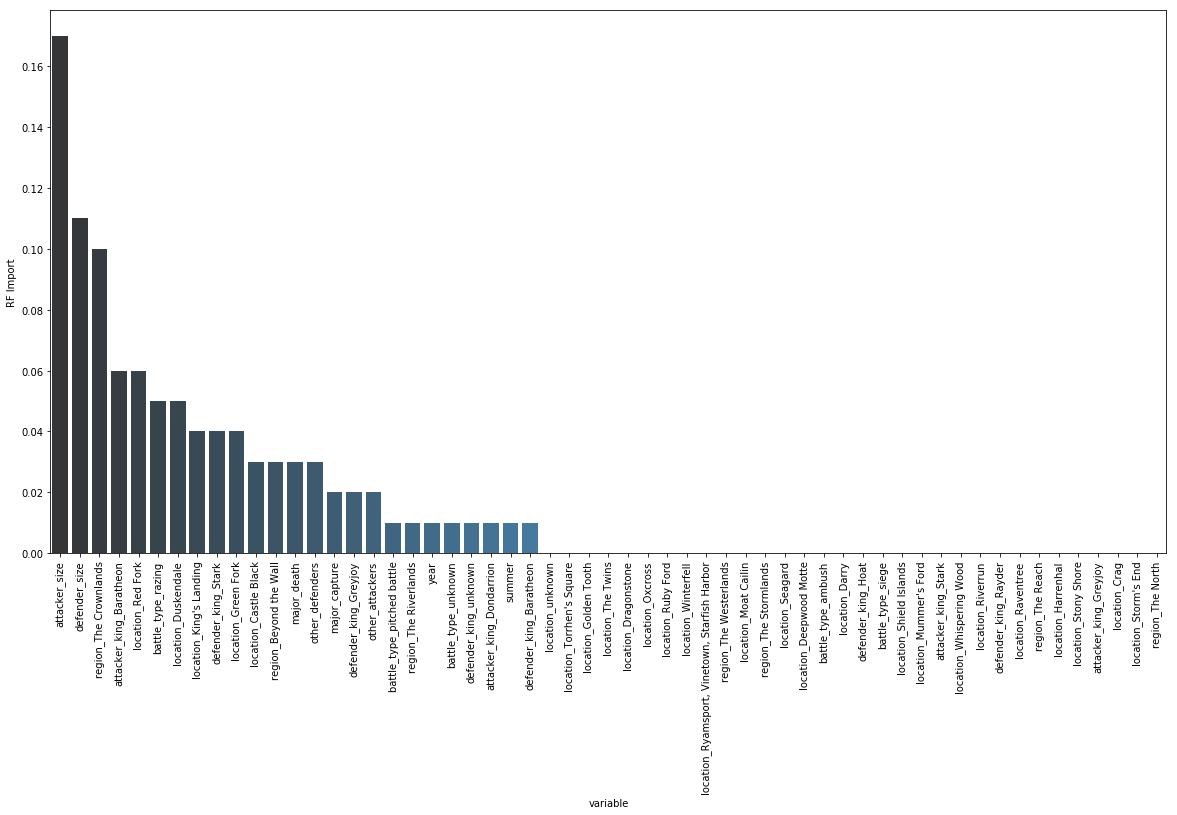

In [132]:
import seaborn as sns
randimportances = randimportances.sort_values(by='RF Import', ascending = False)
sns.barplot(x=randimportances['variable'], y=randimportances['RF Import'], palette="Blues_d")
plt.xticks(rotation=90)
plt.rcParams['figure.figsize']=(20,10)